# Text segmentation using Hidden Markov Models 

                                                           Reme Raphael

### 1/ Give the value of the π vector of the initial probabilities

As there is no mail without a header. All the mails begin with one. It means that the initital vector is : $\pi = 
\begin{pmatrix}1 & 0\end{pmatrix}$

### 2/ What is the probability to move from state 1 to state 2 ? What is the probability to remain in state 2 ? What is the lower/higher probability ? Try to explain why

At each character, the probability to move from state 1 to state 2 is given by $A[1,2] = 0.000781921964187974$. It is compute on a small corpus of mails. One can see that in each mail there only is 1 transition from state 1 to state 2. It explains why its probability is low (It's close to $\frac{1}{1200}$. We could interpret 1200 as the mean size of the header)


Once it is in state 2. It can't go back to state 1. Therefore the probability to remain in state 2 is 1 ($A[2,2]$)

The lower probability will always be the transition from state 2 to state 1 (it always be zero) followed by the transition from state 1 to state 2 as it stays very unlikely.

The higher probability is consequently the transition from state2 to state 2 (always be 1) followed by the transition from state 1 to state 1.

### 3/ What is the size of B ?

B represent the probability distribution of characters in each state. Therefore it has 2 columns and N lines. 

### 4/ Print the track and present and discuss the results obtained on mail11.txt to mail30.txt

In [35]:
import numpy as np


def viterbi(X,Pi0,A,P):
    """
        Viterbi Algorithm Implementation

        Keyword arguments:
            - obs: sequence of observation
            - states:list of states
            - start_prob:vector of the initial probabilities
            - trans: transition matrix
            - emission_prob: emission probability matrix
        Returns:
            - seq: sequence of state
    """

    #pour eviter d avoir des valeurs nulles dans le log
    realmin = np.finfo(np.double).tiny
    
    A = np.log(A+realmin)
    Pi0 = np.log(Pi0+realmin)
    P = np.log(P+realmin)
    
    T = X.shape[0] #nombre d observations
    N = Pi0.shape[0]#nombre des etats du modele
    
    #Initialisation
    logl = np.zeros((T,N))
    bcktr = np.zeros((T-1,N), dtype = int)
    
    logl[0,:]=Pi0+P[X[0],:]
    
    for t in range(T-1):
        temp = A + logl[t,:].reshape((N,1))
        
        bcktr[t,:] = np.argmax(temp, axis = 0)
        logl[t+1,:] = P[X[t+1],:] + np.amax(temp, axis = 0)
        
    path = np.zeros(T, dtype = int)
    path[T-1] = np.argmax(logl[T-1,:])
    
    for t in range(T-2,-1,-1):
        path[t] = bcktr[t,path[t+1]]
        
    return logl, path


In [37]:
Pi0 = np.array([1,0])
A = np.array([[0.999218078035812, 0.000781921964187974], [0, 1]])
B = np.loadtxt("P.text")

mails = []
paths = []
for i in range(11,31):
    mails.append(np.loadtxt("dat/mail" + str(i) + ".dat", dtype = int))
    paths.append(viterbi(mails[i-11], Pi0, A, B)[1])

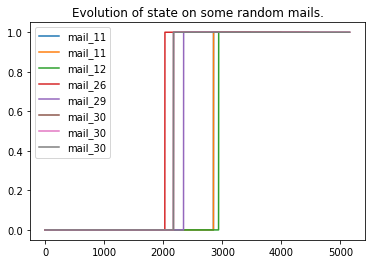

In [38]:
from matplotlib import pyplot as plt
indexes = np.sort(np.random.choice(range(11,31), 8))

for index in indexes:
    plt.plot(paths[index-11], label = "mail_"+str(index))

plt.title("Evolution of state on some random mails.")
plt.legend()
plt.show()

#### One example on a random mail :

In [46]:
index = np.random.choice(range(11,31))
print("index :", index)
path = paths[index-11]
path_file = "path.txt"

with open(path_file, "w") as file:
    for value in path:
        file.write(str(value+1))
        
for i in range(1, len(path)):
    if path[i] != path[i-1]:
        print("Beginning of the body :", i)

index : 11
Beginning of the body : 2851


In [47]:
## NOTE: segment.pl has been modified in order to print only the resulting mail.
import os
os.system("perl segment.pl dat/mail"+str(index)+".txt " + path_file + "> mail.txt")

with open("mail.txt", "r") as file:
    print(file.read())

From spamassassin-devel-admin@lists.sourceforge.net  Thu Aug 22 15:25:29 2002
Return-Path: <spamassassin-devel-admin@example.sourceforge.net>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id AE2D043F9B
	for <zzzz@localhost>; Thu, 22 Aug 2002 10:25:29 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 15:25:29 +0100 (IST)
Received: from usw-sf-list2.sourceforge.net (usw-sf-fw2.sourceforge.net
    [216.136.171.252]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id
    g7MENlZ09984 for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 15:23:47 +0100
Received: from usw-sf-list1-b.sourceforge.net ([10.3.1.13]
    helo=usw-sf-list1.sourceforge.net) by usw-sf-list2.sourceforge.net with
    esmtp (Exim 3.31-VA-mm2 #1 (Debian)) id 17hsof-00042r-00; Thu,
    22 Aug 2002 07:20:05 -0700
Received: from vivi.upti

We can see that this is working quite well. It seems to cut the mail almost at the right place each time. 

We could maybe improve the result as we know a little bit more about the separation between body and header : They are never on the same line. We could for instance choose the nearest '\n' from the cut as the new (and hopefully better) cut.  

### 5/ How would you model the problem if you had to segment the mails in more than two parts (for example : header, body, signature) ?
Draw a diagram of the corresponding Hidden Markov model and give an example of A matrix that would be suitable in this case.

I would do the same but with three states :

![](schema.jpg)

A possible matrix A would be :
$\begin{pmatrix}
1-\epsilon_1 & \epsilon_1 & 0\\
0 & 1-\epsilon_2 & \epsilon_2\\
0 & 0 & 1
\end{pmatrix}$. Indeed you can't go back from a body to header or from signature to body (and header). And you can't jump from header to signature. Moreover the probability to change of state is low. Therefore all $\epsilon_i$ are low.

We could have $\epsilon_1 \cong 0.0007$ (It should not be a lot diffferent as before). And as most of the body we saw in that database are smaller than the header. The probability to jump should be higher, meaning that $\epsilon_2 \gt \epsilon_1$.

We would also have the initital vector $\pi = 
\begin{pmatrix}1 & 0 & 0\end{pmatrix}$

### 6/ How would you model the problem of separating the portions of mail included, knowing that they always start with the character ">". 
Draw a diagram of the corresponding Hidden Markov model.

We could add transition states. If we take back the example of the question 5 with 3 portions. If we know that they are separated by a ">", we could make a slightly different diagram with those transition states :
![](schema_2.jpg)

The header, body and signature states would be the same (Same transition probability and same observation probability). 

For the transition states it's a little bit different. It can't stay on it more than one step. And the observation probability on that state would be : 1 for '>' and 0 for all others characters. 